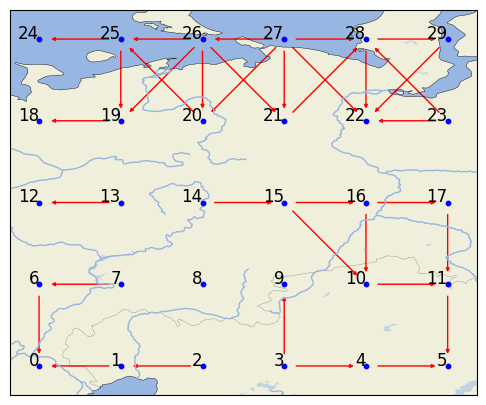

In [1]:
# wind_vector.py
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import networkx as nx
import cartopy

from Caulimate.Utils.GraphUtils import decycle_till_dag
from Caulimate.Utils.Tools import recover_coordinates, scp_transfer_file
from Caulimate.Utils.Visualization import plot_causal_graph

Bs = np.load('/home/minghao.fu/workspace/climate/LinGau/WB/20240427-012634/epoch_900/Bs_pred.npy')
coords = np.load('/home/minghao.fu/workspace/climate/LinGau/WB/20240427-012634/coords.npy')

u = xr.open_mfdataset('/l/users/minghao.fu/dataset/WeatherBench_data_full/u_component_of_wind/*.nc', combine='by_coords')
v = xr.open_mfdataset('/l/users/minghao.fu/dataset/WeatherBench_data_full/v_component_of_wind/*.nc', combine='by_coords')
fig, ax = plt.subplots(
    figsize=(10, 5),
    subplot_kw={'projection': ccrs.PlateCarree()},
)
time_idx=1000
offset = 2
ax.set_extent([np.min(coords[:, 1]) - offset, np.max(coords[:, 1]) + offset, np.min(coords[:, 0]) - offset, np.max(coords[:, 0]) + offset], crs=ccrs.PlateCarree())
# ax.stock_img()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE,linewidth=0.3)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':',linewidth=0.3)
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.add_feature(cartopy.feature.RIVERS)
#ax.set_xticks([65, 80], crs=ccrs.PlateCarree())
# ax.set_xlabel('Longitude', fontsize=12)
# ax.set_ylabel('Latitude')
# ax.set_title('Sea Surface Temperature (SST)')
# gl = ax.gridlines(draw_labels=True, color='black', alpha=0.5, linestyle='--', dms=True, x_inline=False, y_inline=False)
# gl.top_labels = False  # Disable labels at the top
# gl.right_labels = False  # Disable labels on the right
# gl.xlabel_style = {'size': 6}
# gl.ylabel_style = {'size': 6}

def create_adjacency_matrix(n, m, decay_factor=0.2):
    d = n * m
    adjacency_matrix = np.zeros((d, d))

    # Coordinates for each position in the grid
    x_coords, y_coords = np.divmod(np.arange(d), m)
    
    # Distance matrix calculation
    x_diff = x_coords[:, None] - x_coords
    y_diff = y_coords[:, None] - y_coords
    distance_matrix = np.sqrt(x_diff**2 + y_diff**2)

    # Probability matrix based on distance
    probability_matrix = np.exp(-decay_factor * distance_matrix)

    # Random matrix to determine connections
    random_matrix = np.random.rand(d, d)

    # Create adjacency matrix with probability threshold, avoiding self-loops
    adjacency_matrix = (random_matrix < probability_matrix) & (np.eye(d) == 0)

    return adjacency_matrix

def shuffle_adjacency_matrix(matrix):
    indices = np.arange(matrix.shape[0])
    np.random.shuffle(indices)
    shuffled_matrix = matrix[indices, :][:, indices]
    return shuffled_matrix

dag = Bs[time_idx] #shuffle_adjacency_matrix(Bs[0])
dag = decycle_till_dag(dag)
dag[np.abs(dag) < 0.5] = 0
plot_causal_graph(coords, dag, ax)
plt.savefig(f'{u.isel(time=time_idx).history[:10]}.png')
plt.show()


In [5]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [2]:
u.resample(time='1D')

DatasetResample, grouped over '__resample_dim__'
14610 groups with labels 1979-01-01, ..., 2018-12-31.

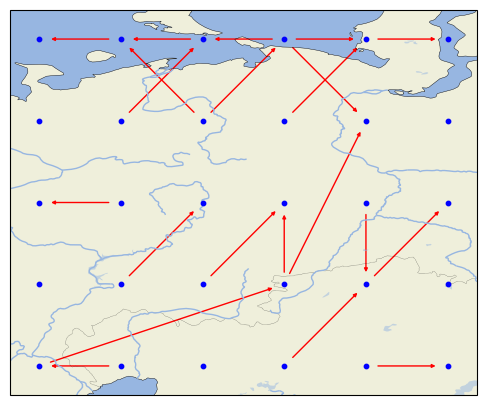

In [13]:
fig, ax = plt.subplots(
    figsize=(10, 5),
    subplot_kw={'projection': ccrs.PlateCarree()},
)

offset = 2
ax.set_extent([np.min(coords[:, 1]) - offset, np.max(coords[:, 1]) + offset, np.min(coords[:, 0]) - offset, np.max(coords[:, 0]) + offset], crs=ccrs.PlateCarree())
#ax.stock_img()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE,linewidth=0.3)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':',linewidth=0.3)
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.add_feature(cartopy.feature.RIVERS)
one_list = [
    [3,10],
    [0,9],
    [20,27],
    [19,26],
    [7,14],
    [9, 22],
    [9,15],
    [10,17],
    [8,15]
]
zero_list = [
    [27,20], 
    [26,19],
    [26,20],
    [27,21],
    [28,22],
    [25,19],
    [26,21],
]
_dag = dag.copy()
for i, j in one_list:
    _dag[i, j] = 1
for i, j in zero_list:
    _dag[i, j] = 0
_dag[np.abs(_dag) < 0.7] = 0
plot_causal_graph(coords, _dag, ax, plot_index=False)
plt.show()

/home/minghao.fu/.conda/envs/minghao_env/lib/python3.12/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home/minghao.fu/.conda/envs/minghao_env/lib/python3.12/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return se

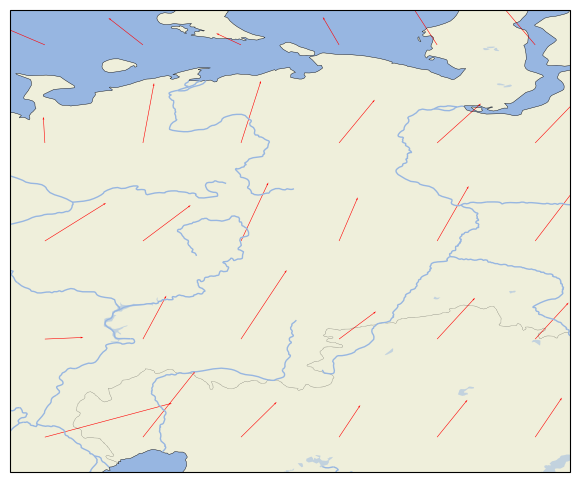

In [4]:
# wind_vector.py
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from Caulimate.Utils.Visualization import plot_causal_graph
from Caulimate.Utils.Tools import recover_coordinates

u = xr.open_mfdataset('/l/users/minghao.fu/dataset/WeatherBench_data_full/u_component_of_wind/*.nc', combine='by_coords')
v = xr.open_mfdataset('/l/users/minghao.fu/dataset/WeatherBench_data_full/v_component_of_wind/*.nc', combine='by_coords')
lat_range = slice(coords[:, 0].min(), coords[:, 0].max())
lon_range = slice(coords[:, 1].min(), coords[:, 1].max())
v_slice = v.isel(time=time_idx).sel(lat=lat_range, lon=lon_range, level=850)['v']
u_slice = u.isel(time=time_idx).sel(lat=lat_range, lon=lon_range, level=850)['u']

u = recover_coordinates(u)
v = recover_coordinates(v)

lon = u_slice.coords['lon']
lat = u_slice.coords['lat']

# Plotting
plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([np.min(coords[:, 1]) - offset, np.max(coords[:, 1]) + offset, np.min(coords[:, 0]) - offset, np.max(coords[:, 0]) + offset], crs=ccrs.PlateCarree())
#ax.stock_img()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE,linewidth=0.3)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':',linewidth=0.3)
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.add_feature(cartopy.feature.RIVERS)

plt.quiver(lon, lat, u_slice, v_slice, scale=100, color='red', width=0.001)  # Adjust the scale parameter
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

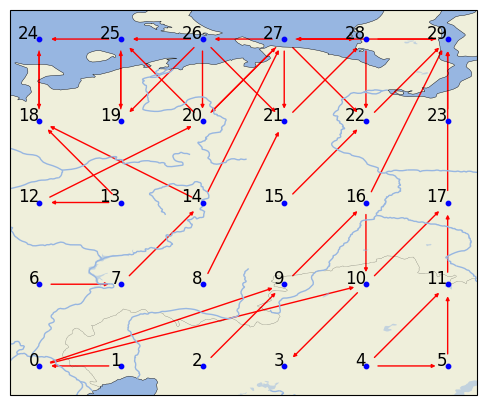

(array([ 0,  0,  1,  2,  4,  4,  5,  6,  7,  8,  9, 10, 10, 11, 12, 13, 13,
        14, 14, 15, 16, 16, 17, 18, 19, 20, 20, 21, 22, 23, 24, 25, 25, 26,
        26, 26, 26, 27, 27, 27, 27, 27, 28, 28, 28, 29]),
 array([ 9, 10,  0,  9,  5, 11, 11,  7, 14, 21, 16,  3, 17, 17, 20, 12, 18,
        18, 27, 22, 10, 29, 29, 24, 25, 25, 27, 28, 29, 29, 18, 19, 24, 19,
        20, 21, 25, 20, 21, 22, 26, 28, 22, 27, 29, 27]))

In [5]:
from Caulimate.Data.WB import create_adjacency_matrix
adj_mat = create_adjacency_matrix(u_slice.values, v_slice.values, lon, lat)
fig, ax = plt.subplots(
    figsize=(10, 5),
    subplot_kw={'projection': ccrs.PlateCarree()},
)

offset = 2
ax.set_extent([np.min(coords[:, 1]) - offset, np.max(coords[:, 1]) + offset, np.min(coords[:, 0]) - offset, np.max(coords[:, 0]) + offset], crs=ccrs.PlateCarree())
#ax.stock_img()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE,linewidth=0.3)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':',linewidth=0.3)
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.add_feature(cartopy.feature.RIVERS)


mat = adj_mat + _dag
mat[np.abs(mat) <= 0.4] = 0  
mat[1, 15] = 0
mat[3, 10] = 0
mat[10, 3] = 1
mat[13, 21] = 0
mat[13, 18] = 1
plot_causal_graph(coords, mat, ax)
plt.show()
mat.nonzero()

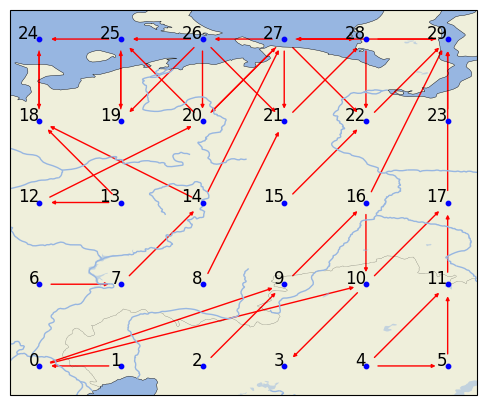

(array([ 0,  0,  1,  2,  4,  4,  5,  6,  7,  8,  9, 10, 10, 11, 12, 13, 13,
        14, 14, 15, 16, 16, 17, 18, 19, 20, 20, 21, 22, 23, 24, 25, 25, 26,
        26, 26, 26, 27, 27, 27, 27, 27, 28, 28, 28, 29]),
 array([ 9, 10,  0,  9,  5, 11, 11,  7, 14, 21, 16,  3, 17, 17, 20, 12, 18,
        18, 27, 22, 10, 29, 29, 24, 25, 25, 27, 28, 29, 29, 18, 19, 24, 19,
        20, 21, 25, 20, 21, 22, 26, 28, 22, 27, 29, 27]))

In [6]:
from Caulimate.Data.WB import create_adjacency_matrix
adj_mat = create_adjacency_matrix(u_slice.values, v_slice.values, lon, lat)
fig, ax = plt.subplots(
    figsize=(10, 5),
    subplot_kw={'projection': ccrs.PlateCarree()},
)

offset = 2
ax.set_extent([np.min(coords[:, 1]) - offset, np.max(coords[:, 1]) + offset, np.min(coords[:, 0]) - offset, np.max(coords[:, 0]) + offset], crs=ccrs.PlateCarree())
#ax.stock_img()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE,linewidth=0.3)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':',linewidth=0.3)
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.add_feature(cartopy.feature.RIVERS)


mat = adj_mat + _dag
mat[np.abs(mat) <= 0.4] = 0  
mat[1, 15] = 0
mat[3, 10] = 0
mat[10, 3] = 1
mat[13, 21] = 0
mat[13, 18] = 1
plot_causal_graph(coords, mat, ax)
plt.show()
mat.nonzero()

In [7]:
def reconstruct_uv_slices(adj_matrix, lat, lon):
    n_lat, n_lon = len(lat), len(lon)
    lon_grid, lat_grid = np.meshgrid(lon, lat)

    # Flatten the grids for easier indexing
    lon_flat = lon_grid.flatten()
    lat_flat = lat_grid.flatten()

    # Initialize u_slice and v_slice
    u_slice = np.zeros_like(lon_grid)
    v_slice = np.zeros_like(lat_grid)

    # Iterate through each grid point in the adjacency matrix
    for i in range(n_lat * n_lon):
        # Get the index of the maximum connection
        j = np.argmax(adj_matrix[i, :])
        if adj_matrix[i, j] > 0:  # Check if there is a connection
            # Calculate the vector components
            u_slice.flat[i] = lon_flat[j] - lon_flat[i]
            v_slice.flat[i] = lat_flat[j] - lat_flat[i]
    return u_slice, v_slice

u_slice_, v_slice_ = reconstruct_uv_slices(mat, lat, lon)
center = 0
plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=center))
ax.coastlines()

adj_matrix = mat / np.max(mat)

plt.quiver(lon - center, lat, u_slice_, v_slice_, scale=500, color='red', width=0.001)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

NameError: name 'adj_matrix' is not defined

/tmp/ipykernel_1869299/212581248.py:47: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, node_pos, ax=ax, arrowstyle='->', arrowsize=20, edge_color='gray')


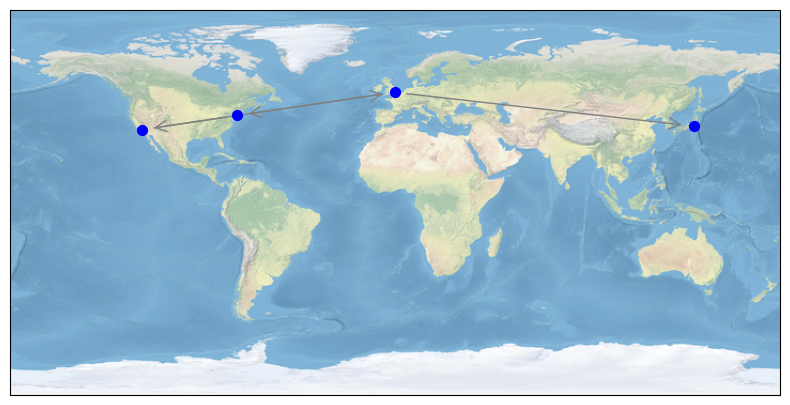

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import networkx as nx

def plot_causal_graph(coords, adj_matrix):
    fig, ax = plt.subplots(
        figsize=(10, 5),
        subplot_kw={'projection': ccrs.PlateCarree()}
    )
    ax.stock_img()

    G = nx.DiGraph()  # Directed graph

    # Add nodes with their geographical coordinates
    for index, (lat, lon) in enumerate(coords):
        G.add_node(index, pos=(lon, lat))

    # Add edges according to the adjacency matrix
    for i in range(len(adj_matrix)):
        for j in range(len(adj_matrix[i])):
            if adj_matrix[i][j] == 1:
                G.add_edge(i, j)

    # Draw the nodes
    node_pos = nx.get_node_attributes(G, 'pos')
    nx.draw_networkx_nodes(G, node_pos, ax=ax, node_size=50, node_color='blue')

    # Draw the edges
    nx.draw_networkx_edges(G, node_pos, ax=ax, arrowstyle='->', arrowsize=20, edge_color='gray')

    plt.show()

# Use the function
plot_causal_graph(coords, adj_matrix)



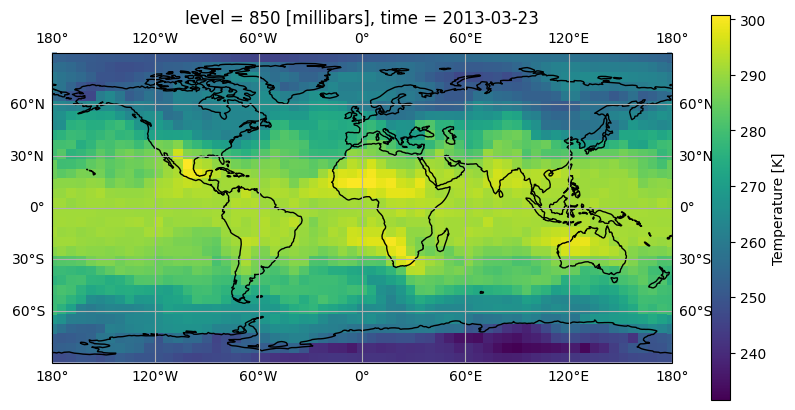

In [ ]:
data_dns = data.coarsen(lat=2, lon=2, boundary='trim').mean()
data_dns.plot(ax=ax, transform=ccrs.PlateCarree(), x='lon', y='lat')